# Import Library

In [1]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


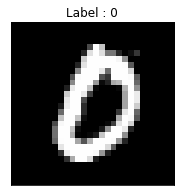

In [3]:
# Check data
train_x, train_y = mnist.train.next_batch(10)
img = train_x[9,:].reshape(28, 28)

plt.figure(figsize=(5, 3))
plt.imshow(img,'gray')
plt.title("Label : {}".format(np.argmax(train_y[9])))
plt.xticks([])
plt.yticks([])
plt.show()

# Build RNN

In [4]:
n_step = 14
n_input = 28

## LSTM shape
n_lstm1 = 128
n_lstm2 = 258

## Fully connected
n_hidden1 = 100
n_output = 28
n_labels = 10

In [5]:
weights = {
    'hidden1' : tf.Variable(tf.random_normal([n_lstm2, n_hidden1], stddev=0.01)),
    'output' : tf.Variable(tf.random_normal([n_hidden1, n_output], stddev=0.01)),
}

biases = {
    'hidden1' : tf.Variable(tf.random_normal([n_hidden1], stddev=0.01)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev=0.01))
}

x = tf.placeholder(tf.float32, [None, n_step, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

In [6]:
def RNN(x, weights, biases):
    # x = tf.unstack(x, n_step, 1)
    with tf.variable_scope('rnn'):
        with tf.variable_scope('lstm1'):
            lstm1 = tf.contrib.rnn.BasicLSTMCell(n_lstm1, forget_bias=1.0)
            h1, c1 = tf.nn.dynamic_rnn(lstm1, x, dtype=tf.float32)
        with tf.variable_scope('lstm2'):
            lstm2 = tf.contrib.rnn.BasicLSTMCell(n_lstm2, forget_bias=1.0)
            h2, c2 = tf.nn.dynamic_rnn(lstm2, h1, dtype=tf.float32)
    
    hidden1 = tf.add(tf.matmul(h2[:,-1,:], weights['hidden1']), biases['hidden1'])
    hidden1 = tf.nn.relu(hidden1)
    output = tf.add(tf.matmul(hidden1, weights['output']), biases['output'])
    return output

# Learning

In [7]:
LR = 0.0002

pred = RNN(x, weights, biases)
loss = tf.square(tf.subtract(y, pred))
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

In [8]:
n_iter = 2500
n_prt = 250

In [19]:
sess = tf.Session()
sess.run(init)

for i in range(n_iter):
    train_x, train_y = mnist.train.next_batch(50)
    train_x = train_x.reshape(-1, 28, 28)
    
    for j in range(n_step):
        sess.run(optm, feed_dict={x: train_x[:,j:j+n_step,:],  y: train_x[:,j+n_step]})
    if i % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x[:,13:13+n_step,:],  y: train_x[:,13+n_step]})
        print ("Iter : {}".format(i))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.00015980041644070297
Iter : 250
Cost : 0.0003884172474499792
Iter : 500
Cost : 0.001244431477971375
Iter : 750
Cost : 0.0021651124116033316
Iter : 1000
Cost : 0.0002789700520224869
Iter : 1250
Cost : 0.00048235783469863236
Iter : 1500
Cost : 0.0028670828323811293
Iter : 1750
Cost : 0.0032489881850779057
Iter : 2000
Cost : 0.0006320722750388086
Iter : 2250
Cost : 0.0005521310376934707


# Predict (data : only MNIST)

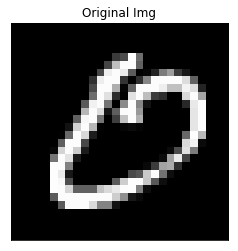

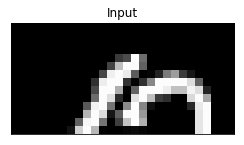

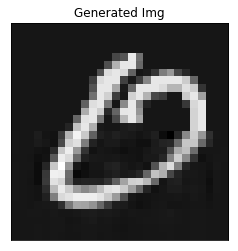

In [149]:
test_x, test_y = mnist.test.next_batch(10)
test_x = test_x.reshape(-1, 28, 28)

idx = 0
gen_img = []
sample = test_x[idx, 0:14, :]
input_img = sample.copy()

for i in range(n_step):
    test_pred = sess.run(pred, feed_dict={x: test_x[idx, i:i+n_step, :].reshape(1, 14, 28)})
    gen_img.append(test_pred)

for i in range(n_step):
    sample = np.vstack([sample, gen_img[i]])
    
plt.imshow(test_x[idx], 'gray')
plt.title('Original Img')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(input_img, 'gray')
plt.title('Input')
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(sample, 'gray')
plt.title('Generated Img')
plt.xticks([])
plt.yticks([])
plt.show()

# Predict (data : first dim 14 == Mnist, other dim 14 == gen_img)

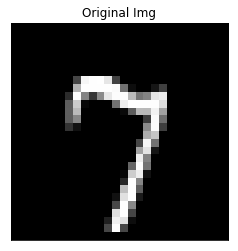

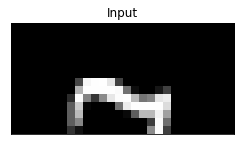

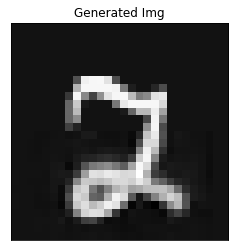

In [157]:
test_x, test_y = mnist.test.next_batch(10)
test_x = test_x.reshape(-1, 28, 28)

idx = 0
gen_img = []

sample = test_x[idx, 0:14, :]
input_img = sample.copy()

feeding_img = test_x[idx, 0:0+n_step, :]

for i in range(n_step):
    test_pred = sess.run(pred, feed_dict={x: feeding_img.reshape(1, 14, 28)})
    feeding_img = np.delete(feeding_img, 0, 0)
    feeding_img = np.vstack([feeding_img, test_pred])
    gen_img.append(test_pred)


for i in range(n_step):
    sample = np.vstack([sample, gen_img[i]])
    
plt.imshow(test_x[idx], 'gray')
plt.title('Original Img')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(input_img, 'gray')
plt.title('Input')
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(sample, 'gray')
plt.title('Generated Img')
plt.xticks([])
plt.yticks([])
plt.show()